In [2]:
import os
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [3]:
csv_path = "transportation_data.csv"
df = pd.read_csv(csv_path)

In [4]:
# Parse dates and sort
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')
df = df.sort_values('Date').reset_index(drop=True)
print("\nRaw dataframe head:")
print(df.head())

# Set index
df = df.set_index('Date')


Raw dataframe head:
        Date  Local Route  Light Rail  Peak Service  Rapid Route  School  \
0 2019-07-01        15987        9962           407        21223    3715   
1 2019-07-02        16895       10656           409        21715    3993   
2 2019-07-03        16613       10658           427        22025    3638   
3 2019-07-04        16604       10445           437        21868    3576   
4 2019-07-05        16040       10532           400        20697    2856   

   Other  
0    NaN  
1    NaN  
2    NaN  
3    NaN  
4    NaN  



--- EDA ---
Shape: (1918, 6)

Missing values per column:
 Local Route      0
Light Rail       0
Peak Service     0
Rapid Route      0
School           0
Other           20
dtype: int64

Descriptive stats:


,count,mean,std,min,25%,50%,75%,max
Local Route,1918.0,9891.395203,6120.715714,1.0,3044.5,11417.0,15517.50,21070.0
Light Rail,1918.0,7195.446298,3345.616428,0.0,4463.5,7507.0,10008.25,15154.0
Peak Service,1918.0,179.581335,156.532738,0.0,0.0,193.0,313.75,1029.0
Rapid Route,1918.0,12597.213243,6720.494557,0.0,6383.0,13106.5,17924.75,28678.0
School,1918.0,2352.694995,2494.766306,0.0,0.0,567.5,4914.00,7255.0
Other,1898.0,43.390411,41.746882,0.0,14.0,40.0,68.00,1105.0



Outlier summary (IQR method):
 - Local Route: 0 outliers; bounds (-15665.0,34227.0)
 - Light Rail: 0 outliers; bounds (-3853.625,18325.375)
 - Peak Service: 1 outliers; bounds (-470.625,784.375)
 - Rapid Route: 0 outliers; bounds (-10929.625,35237.375)
 - School: 0 outliers; bounds (-7371.0,12285.0)
 - Other: 9 outliers; bounds (-67.0,149.0)


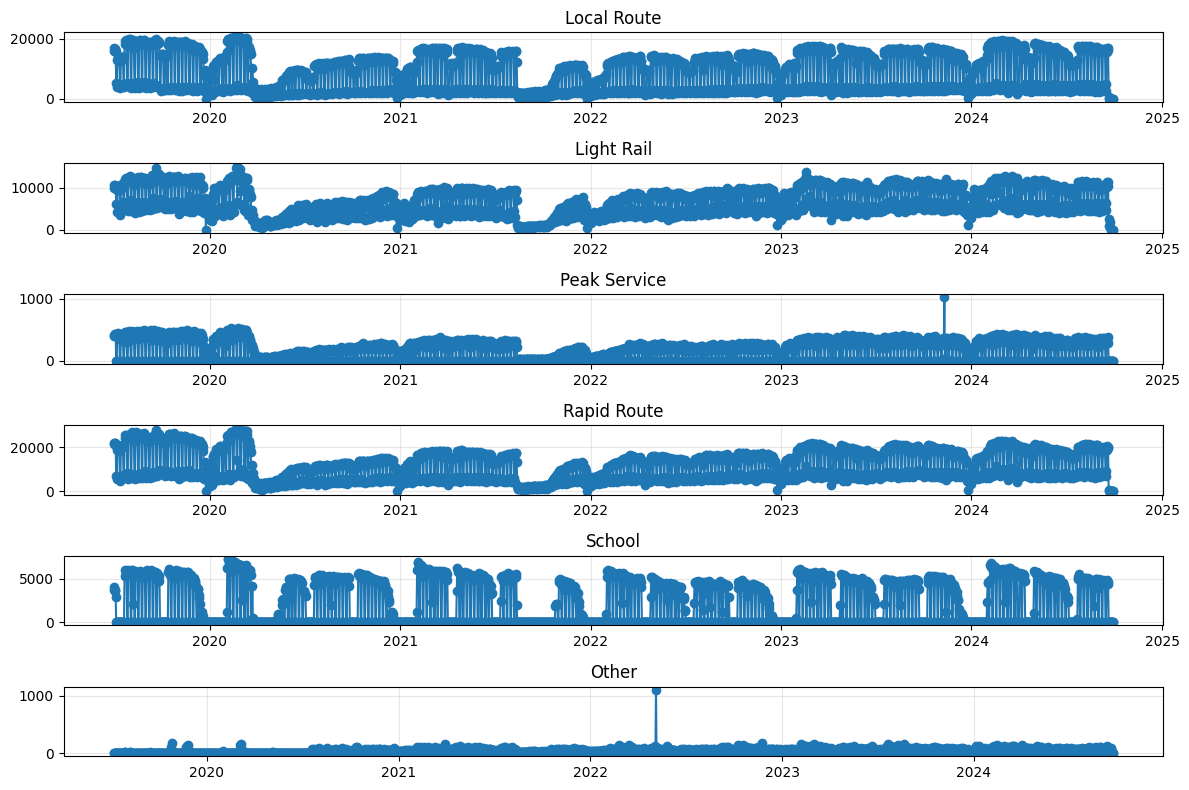

In [5]:

# -------------------------------
# 2) EDA: basic checks, missing, outliers
# -------------------------------
print("\n--- EDA ---")
print("Shape:", df.shape)
print("\nMissing values per column:\n", df.isna().sum())

print("\nDescriptive stats:")
display(df.describe().T)

# Outlier detection via IQR for each series
outlier_summary = {}
for col in df.columns:
    series = df[col].dropna().astype(float)
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    outliers = series[(series < lower) | (series > upper)]
    outlier_summary[col] = {"n_outliers": len(outliers),
                            "outlier_indices": outliers.index.tolist(),
                            "lower": lower, "upper": upper}
print("\nOutlier summary (IQR method):")
for k,v in outlier_summary.items():
    print(f" - {k}: {v['n_outliers']} outliers; bounds ({v['lower']},{v['upper']})")

# Visualize raw series
plt.figure(figsize=(12,8))
for i, col in enumerate(df.columns, 1):
    plt.subplot(len(df.columns),1,i)
    plt.plot(df[col], marker='o')
    plt.title(col)
    plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# If missing or NaT present
if df.index.isnull().any() or df.isna().any().any():
    print("\nWarning: missing dates or values found. Consider cleaning or imputing real data.")



In [6]:
#3) Handling irregular spacing: resample to daily and interpolate (explicit assumption)
# -------------------------------
# If the time index is not regular, many TS methods need a regular freq. We'll:
#  - create a daily index between min and max date
#  - reindex to daily and linearly interpolate missing points
# This creates synthetic intermediate points and must be noted in reports.

min_date = df.index.min()
max_date = df.index.max()
n_original = len(df)
print(f"\nData spans {min_date.date()} to {max_date.date()} ({n_original} original observations)")

# Build daily index
daily_index = pd.date_range(start=min_date, end=max_date, freq='D')
df_daily = df.reindex(daily_index)

# Linear interpolation (numeric)
df_daily_interpolated = df_daily.interpolate(method='linear', limit_direction='both')

print("\nAfter reindexing to daily frequency and linear interpolation:")
print("New length:", len(df_daily_interpolated))
display(df_daily_interpolated.head(8))

# Use df_model for stationarity checks and modeling
df_model = df_daily_interpolated.copy()



Data spans 2019-07-01 to 2024-09-29 (1918 original observations)

After reindexing to daily frequency and linear interpolation:
New length: 1918


,Local Route,Light Rail,Peak Service,Rapid Route,School,Other
2019-07-01,15987,9962,407,21223,3715,0.0
2019-07-02,16895,10656,409,21715,3993,0.0
2019-07-03,16613,10658,427,22025,3638,0.0
2019-07-04,16604,10445,437,21868,3576,0.0
2019-07-05,16040,10532,400,20697,2856,0.0
2019-07-06,5214,6141,0,6925,0,0.0
2019-07-07,4065,4332,0,5426,0,0.0
2019-07-08,13078,9442,422,18848,0,0.0


In [7]:
# 4) Stationarity check: ADF test (levels)
# -------------------------------
def adf_report(series, title=None):
    series = series.dropna()
    if len(series) < 3:
        return {"error":"too few observations for ADF"}
    res = adfuller(series, autolag='AIC')
    out = {"ADF Statistic": res[0], "p-value": res[1], "usedlag": res[2], "nobs": res[3]}
    if title:
        print(f"\nADF test for {title}: ADF={out['ADF Statistic']:.4f}, p-value={out['p-value']:.4f}, nobs={out['nobs']}")
    return out

adf_before = {}
print("\n--- ADF test on original (interpolated) series ---")
for col in df_model.columns:
    adf_before[col] = adf_report(df_model[col], title=col)


--- ADF test on original (interpolated) series ---

ADF test for Local Route: ADF=-4.5800, p-value=0.0001, nobs=1896

ADF test for Light Rail: ADF=-3.4961, p-value=0.0081, nobs=1891

ADF test for Peak Service: ADF=-3.8707, p-value=0.0023, nobs=1896

ADF test for Rapid Route: ADF=-3.8281, p-value=0.0026, nobs=1896

ADF test for School: ADF=-7.1339, p-value=0.0000, nobs=1893

ADF test for Other: ADF=-3.5536, p-value=0.0067, nobs=1891



ADF test for Local Route (level): ADF=-4.5800, p-value=0.0001, nobs=1896

ADF test for Local Route (1st diff): ADF=-10.6254, p-value=0.0000, nobs=1890

ADF test for Light Rail (level): ADF=-3.4961, p-value=0.0081, nobs=1891

ADF test for Light Rail (1st diff): ADF=-10.2427, p-value=0.0000, nobs=1890

ADF test for Peak Service (level): ADF=-3.8707, p-value=0.0023, nobs=1896

ADF test for Peak Service (1st diff): ADF=-12.3738, p-value=0.0000, nobs=1890

ADF test for Rapid Route (level): ADF=-3.8281, p-value=0.0026, nobs=1896

ADF test for Rapid Route (1st diff): ADF=-10.0489, p-value=0.0000, nobs=1890

ADF test for School (level): ADF=-7.1339, p-value=0.0000, nobs=1893

ADF test for School (1st diff): ADF=-11.1829, p-value=0.0000, nobs=1890

ADF test for Other (level): ADF=-3.5536, p-value=0.0067, nobs=1891

ADF test for Other (1st diff): ADF=-13.8162, p-value=0.0000, nobs=1890

Differencing decisions (d) per series:
{'Local Route': 1, 'Light Rail': 1, 'Peak Service': 1, 'Rapid Route': 

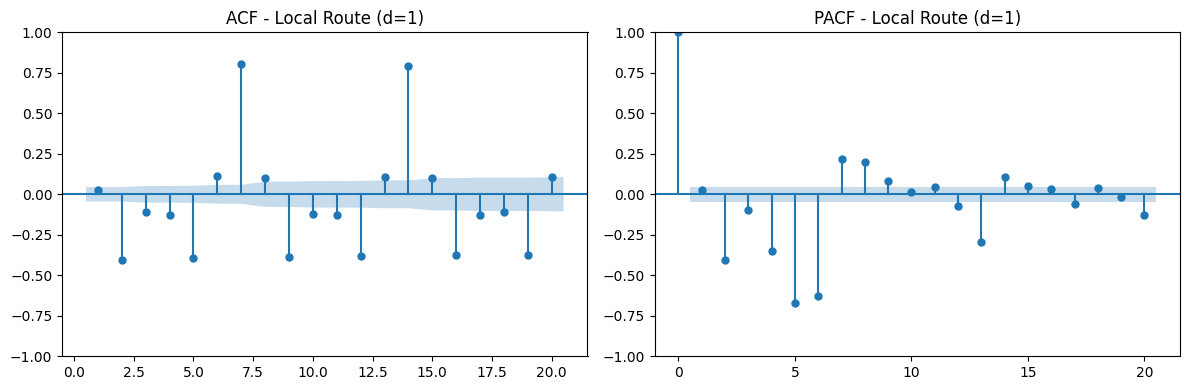

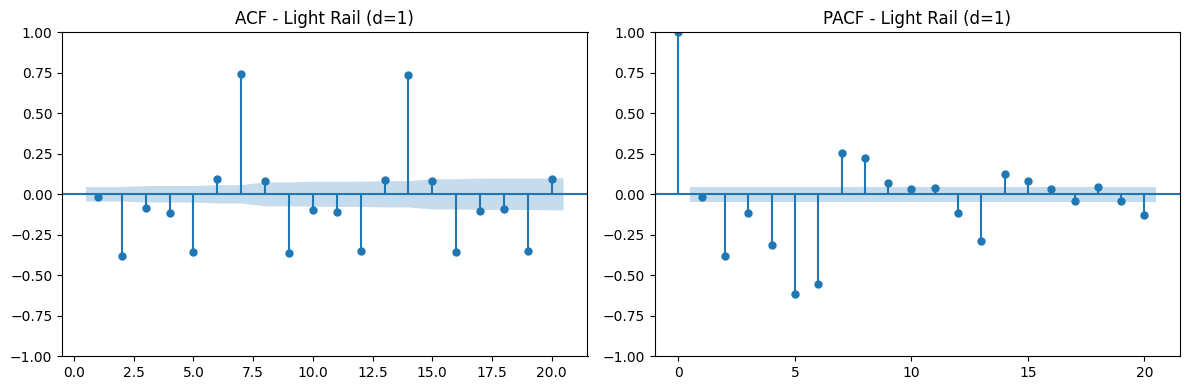

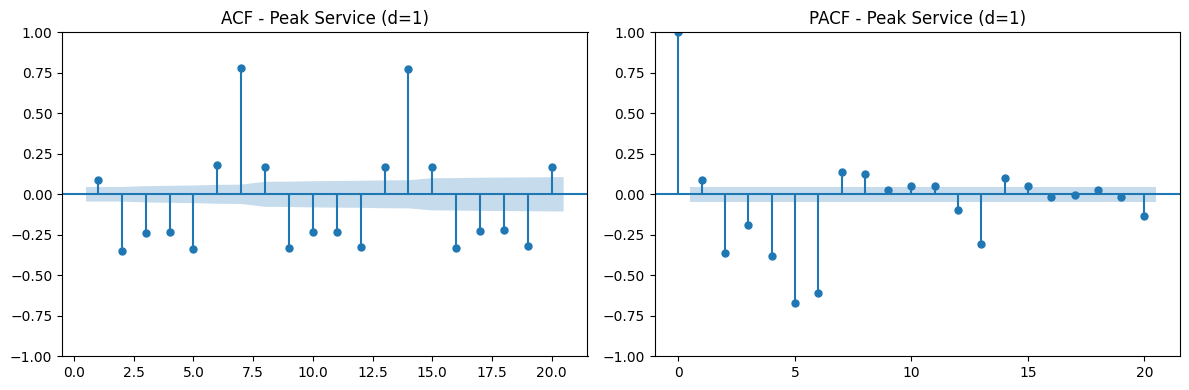

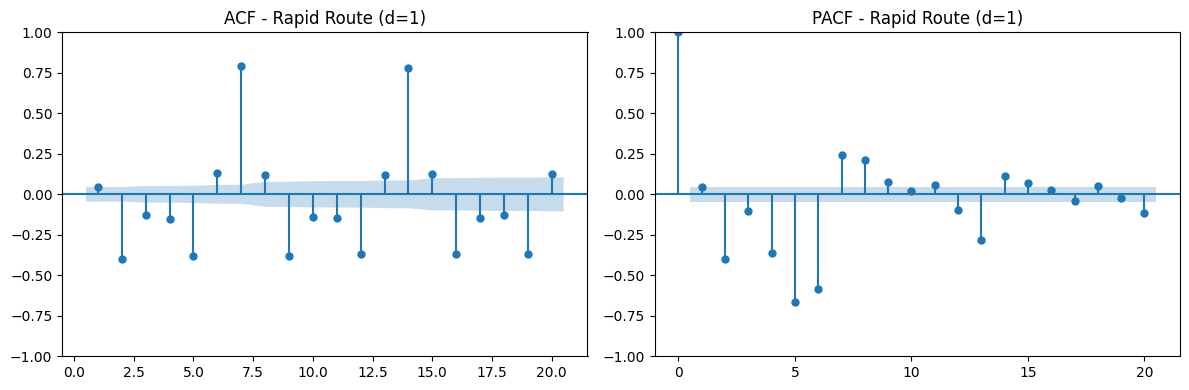

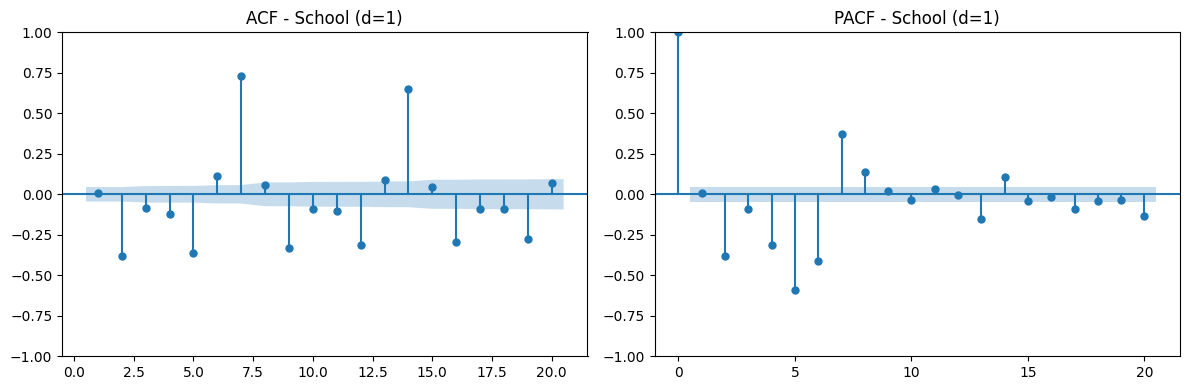

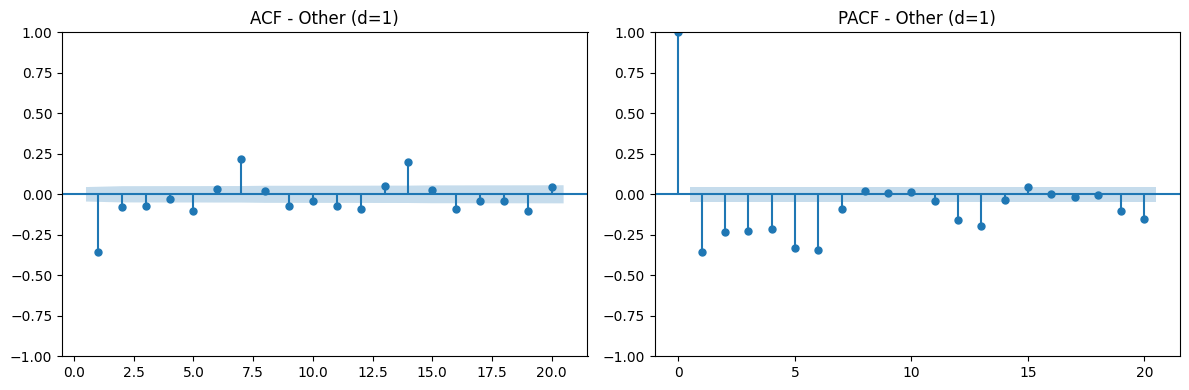

In [8]:
# 5) Differencing until stationary (max d=2)
# -------------------------------
df_diff = df_model.copy()
d_used = {}
adf_after = {}

for col in df_model.columns:
    series = df_model[col].dropna()
    d = 0
    adf_p = adf_report(series, title=f"{col} (level)")
    # try d=1
    series_d1 = series.diff().dropna()
    adf_d1 = adf_report(series_d1, title=f"{col} (1st diff)")
    if (isinstance(adf_d1, dict) and adf_d1.get('p-value', 1.0) <= 0.05):
        d = 1
        adf_after[col] = adf_d1
    else:
        # try d=2
        series_d2 = series.diff().diff().dropna()
        adf_d2 = adf_report(series_d2, title=f"{col} (2nd diff)")
        if (isinstance(adf_d2, dict) and adf_d2.get('p-value', 1.0) <= 0.05):
            d = 2
            adf_after[col] = adf_d2
        else:
            # fallback to d=1 (even if borderline), respecting your instruction to difference once first
            d = 1
            adf_after[col] = adf_d1
    d_used[col] = d

print("\nDifferencing decisions (d) per series:")
print(d_used)

# -------------------------------
# 6) ACF & PACF plots to guide p and q
# -------------------------------
print("\n--- ACF & PACF plots (use these to pick p and q) ---")
fig_count = 0
for col in df_model.columns:
    d = d_used[col]
    series = df_model[col].dropna()
    if d >= 1:
        series_to_plot = series.diff().dropna()
    else:
        series_to_plot = series
    fig = plt.figure(figsize=(12,4))
    ax1 = fig.add_subplot(121)
    plot_acf(series_to_plot, lags=20, ax=ax1, zero=False)
    ax1.set_title(f"ACF - {col} (d={d})")
    ax2 = fig.add_subplot(122)
    plot_pacf(series_to_plot, lags=20, ax=ax2, method='ywm')
    ax2.set_title(f"PACF - {col} (d={d})")
    plt.tight_layout()
    plt.show()
    fig_count += 1


In [9]:
# 7) Model selection: small grid search for ARIMA(p,d,q) using AIC
#    p and q in 0..2 to prevent overfitting given small data
# -------------------------------
print("\n--- SARIMAX model selection (grid search p,q in 0..2) ---")
orders_tried = {}
best_models = {}
for col in df_model.columns:
    series = df_model[col].dropna()
    d = d_used.get(col,1)
    best_aic = np.inf
    best_order = None
    best_res = None
    orders_tried[col] = []
    # restrict p,q to 0..2 because of small sample and avoid overfitting
    for p in range(0,3):
        for q in range(0,3):
            try:
                mod = SARIMAX(series, order=(p,d,q), enforce_stationarity=False, enforce_invertibility=False)
                res = mod.fit(disp=False, maxiter=50)
                orders_tried[col].append(((p,d,q), res.aic))
                if res.aic < best_aic:
                    best_aic = res.aic
                    best_order = (p,d,q)
                    best_res = res
            except Exception as e:
                # skip failed fits
                continue
    if best_order is None:
        # fallback
        best_order = (1,d,1)
        mod = SARIMAX(series, order=best_order, enforce_stationarity=False, enforce_invertibility=False)
        best_res = mod.fit(disp=False, maxiter=50)
        best_aic = best_res.aic
    best_models[col] = {"order": best_order, "aic": best_aic, "result": best_res}
    print(f"{col:12s} -> best order: {best_order}, AIC: {best_aic:.2f}")



--- SARIMAX model selection (grid search p,q in 0..2) ---
Local Route  -> best order: (2, 1, 2), AIC: 37507.03
Light Rail   -> best order: (2, 1, 2), AIC: 34611.05
Peak Service -> best order: (2, 1, 2), AIC: 23192.16
Rapid Route  -> best order: (2, 1, 2), AIC: 37422.17
School       -> best order: (2, 1, 2), AIC: 34193.20
Other        -> best order: (2, 1, 2), AIC: 19109.01


In [ ]:
# 8) Train/test evaluation
print("\n--- Evaluation (time-based split) ---")
metrics = {}
for col, info in best_models.items():
    series = df_model[col].dropna()
    n = len(series)
    if n < 30:
        split_idx = n-1  # train on first n-1, test on last 1
    else:
        split_idx = int(n*0.8)
    train = series.iloc[:split_idx]
    test = series.iloc[split_idx:]
    order = info['order']
    try:
        model = SARIMAX(train, order=order, enforce_stationarity=False, enforce_invertibility=False)
        res = model.fit(disp=False, maxiter=50)
        # forecast horizon = len(test)
        fc = res.get_forecast(steps=len(test))
        yhat = fc.predicted_mean
        # metrics
        mae = mean_absolute_error(test, yhat)
        rmse = np.sqrt(mean_squared_error(test, yhat))
        # MAPE robust: avoid divide by zero
        test_nonzero = test.copy()
        test_nonzero[test_nonzero==0] = np.nan
        mape = np.mean(np.abs((test - yhat) / test_nonzero)) * 100
        metrics[col] = {"MAE": float(mae), "RMSE": float(rmse), "MAPE%": float(mape), "test_values": test.values.tolist(), "predicted": yhat.values.tolist()}
    except Exception as e:
        metrics[col] = {"error": str(e)}
    print(f"{col:12s} - evaluated. Test size: {len(test)}")

print("\nEvaluation metrics (per series):")
for k,v in metrics.items():
    print(k, "->", {kk: (round(vv,3) if isinstance(vv,(int,float)) else vv) for kk,vv in v.items() if kk in ['MAE','RMSE','MAPE%']})


--- Evaluation (time-based split) ---
Local Route  - evaluated. Test size: 384
Light Rail   - evaluated. Test size: 384
Peak Service - evaluated. Test size: 384
Rapid Route  - evaluated. Test size: 384
School       - evaluated. Test size: 384
Other        - evaluated. Test size: 384

Evaluation metrics (per series):
Local Route -> {'MAE': 5529.799, 'RMSE': 6313.164, 'MAPE%': 7921.198}
Light Rail -> {'MAE': 2457.413, 'RMSE': 3021.233, 'MAPE%': 75.484}
Peak Service -> {'MAE': 142.326, 'RMSE': 167.628, 'MAPE%': 132.275}
Rapid Route -> {'MAE': 5223.52, 'RMSE': 6256.238, 'MAPE%': 3636.743}
School -> {'MAE': 2488.08, 'RMSE': 2677.455, 'MAPE%': 5872.893}
Other -> {'MAE': 26.46, 'RMSE': 33.102, 'MAPE%': 96.971}


In [ ]:
# 9) Refit on full data and forecast next 7 days
horizon = 7
future_index = pd.date_range(start=df_model.index.max() + pd.Timedelta(days=1), periods=horizon, freq='D')
forecasts = pd.DataFrame(index=future_index)

for col, info in best_models.items():
    series = df_model[col].dropna()
    order = info['order']
    res_full = SARIMAX(series, order=order, enforce_stationarity=False, enforce_invertibility=False).fit(disp=False, maxiter=50)
    fc = res_full.get_forecast(steps=horizon)
    forecasts[col] = fc.predicted_mean
    forecasts[col + "_lower"] = fc.conf_int().iloc[:,0].values
    forecasts[col + "_upper"] = fc.conf_int().iloc[:,1].values

print("\n7-day point forecasts:")
display(forecasts[[c for c in forecasts.columns if not c.endswith("_lower") and not c.endswith("_upper")]])



7-day point forecasts:


,Local Route,Light Rail,Peak Service,Rapid Route,School,Other
2024-09-30,4110.602250,2506.192187,95.334836,4079.357334,596.592647,34.369894
2024-10-01,5532.394443,3495.364766,130.936129,5593.709454,893.450906,40.912777
2024-10-02,4199.084265,2935.632624,98.434526,4363.910222,837.663110,38.042387
2024-10-03,2010.223329,1857.240938,39.868421,2196.772116,630.601401,34.432426
2024-10-04,807.627106,1208.420787,3.878706,935.861626,477.837348,32.391923
2024-10-05,1096.276038,1247.850540,9.530952,1154.720731,453.381367,31.686142
2024-10-06,2153.459006,1659.446243,41.156325,2190.926143,513.093330,31.620356


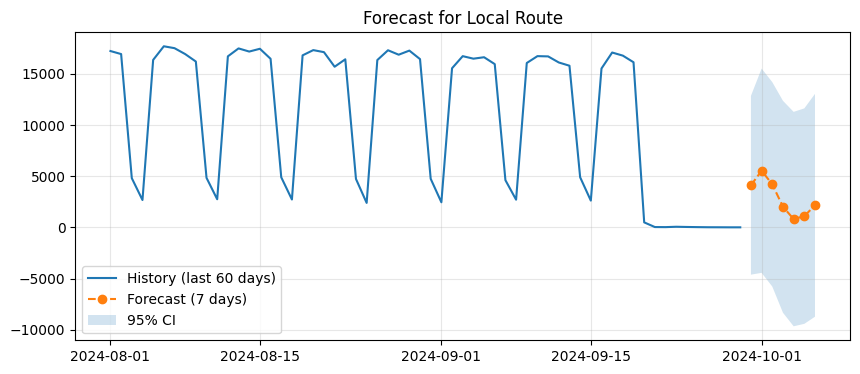

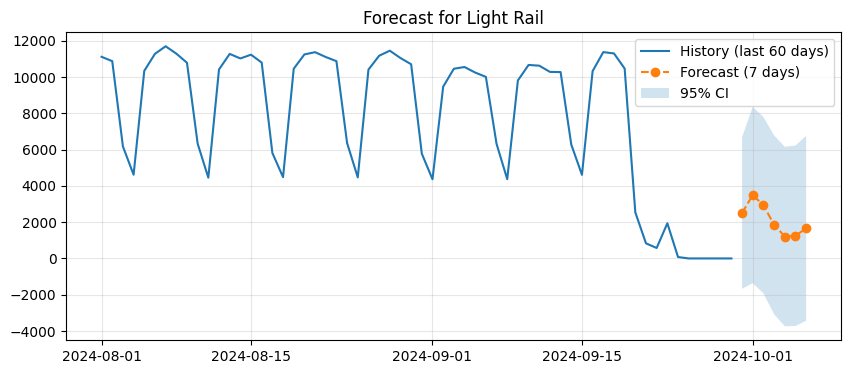

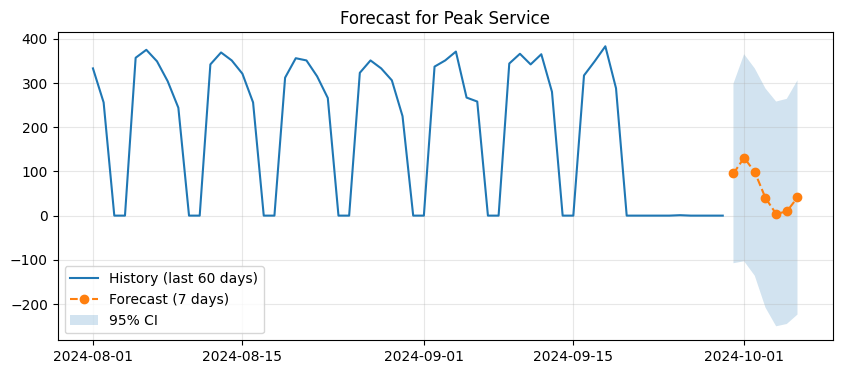

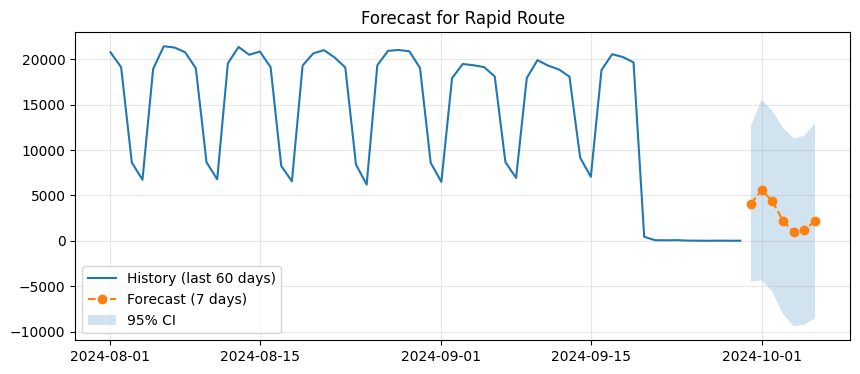

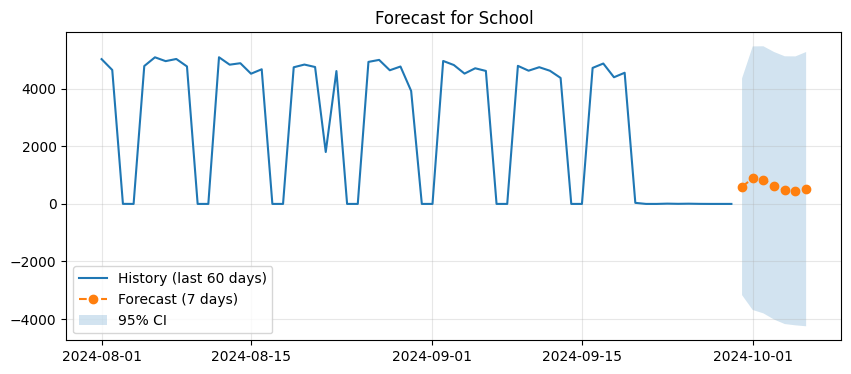

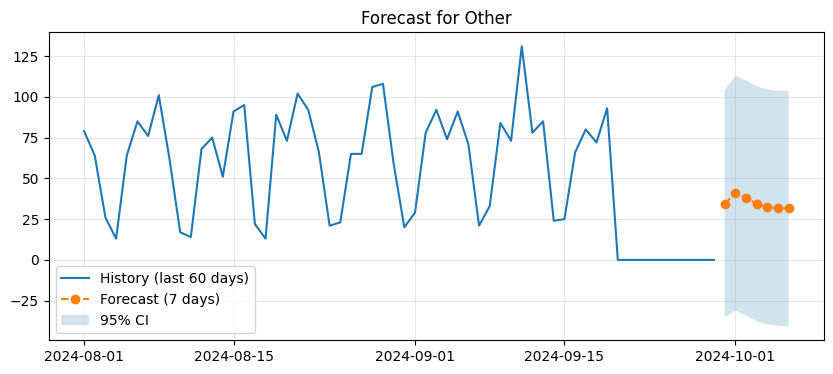

In [ ]:
# 10) Visualize predictions with history and confidence intervals
for col in df_model.columns:
    plt.figure(figsize=(10,4))
    plt.plot(df_model[col].iloc[-60:], label="History (last 60 days)")  # last 60 days of interpolated data
    plt.plot(forecasts[col], linestyle='--', marker='o', label="Forecast (7 days)")
    plt.fill_between(forecasts.index, forecasts[col + "_lower"], forecasts[col + "_upper"], alpha=0.2, label="95% CI")
    plt.title(f"Forecast for {col}")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

In [ ]:
# 11) Save forecast table to CSV
out_csv = "forecast_7day.csv"
# only save point forecasts
forecasts_points = forecasts[[c for c in forecasts.columns if not c.endswith("_lower") and not c.endswith("_upper")]]
forecasts_points.to_csv(out_csv, index_label='Date')
print(f"\nSaved 7-day forecasts to {out_csv}")


Saved 7-day forecasts to forecast_7day.csv


                               SARIMAX Results                                
Dep. Variable:            Local Route   No. Observations:                 1534
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -15211.906
Date:                Tue, 04 Nov 2025   AIC                          30429.812
Time:                        10:57:54   BIC                          30445.817
Sample:                    07-01-2019   HQIC                         30435.768
                         - 09-11-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4474      0.022     20.654      0.000       0.405       0.490
ma.L1         -0.9618      0.009   -103.972      0.000      -0.980      -0.944
sigma2      2.433e+07   2.39e-10   1.02e+17      0.0

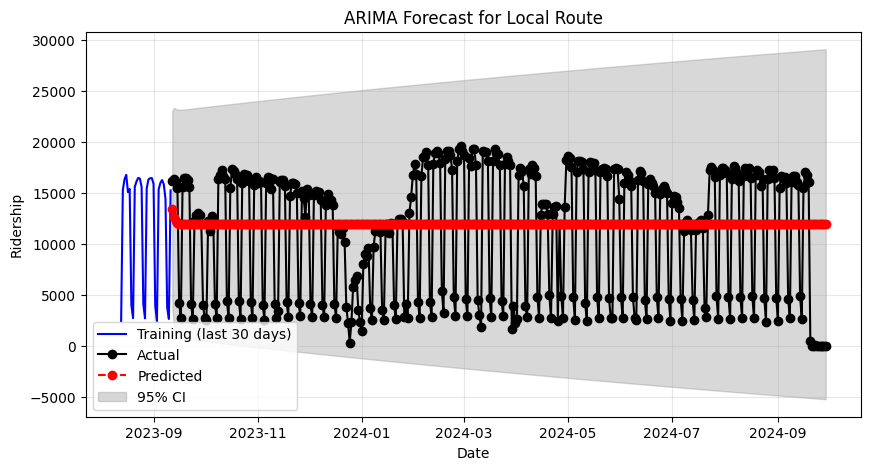


Next 7-Day Forecast:
2023-09-12    13432.317266
2023-09-13    12612.289392
2023-09-14    12245.370612
2023-09-15    12081.194008
2023-09-16    12007.733725
2023-09-17    11974.864163
2023-09-18    11960.156785
Freq: D, Name: predicted_mean, dtype: float64


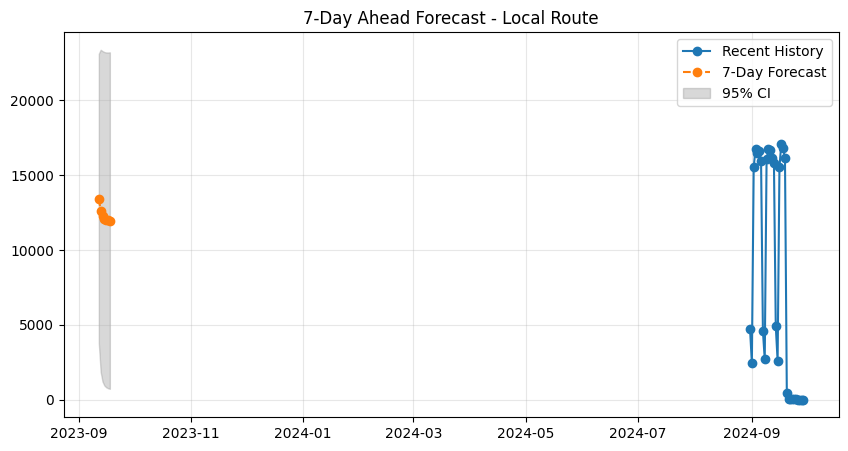

In [13]:
# ============================================
# ARIMA MODELING, FORECASTING, EVALUATION, VISUALIZATION
# ============================================

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Choose the target variable (one column at a time)
target_col = 'Local Route'   # Change to 'Light Rail', 'Rapid Route', etc.
y = df_model[target_col]

# --- 1. Train-Test Split (last 20% for testing) ---
train_size = int(len(y) * 0.8)
train, test = y.iloc[:train_size], y.iloc[train_size:]

# --- 2. Fit ARIMA Model ---
# Adjust p,d,q as found from ACF/PACF
order = (1, 1, 1)
model = ARIMA(train, order=order)
res = model.fit()
print(res.summary())

# --- 3. Predict & Forecast ---
forecast_steps = len(test)
pred = res.get_forecast(steps=forecast_steps)
pred_mean = pred.predicted_mean
conf_int = pred.conf_int()

# --- 4. Evaluate Forecast ---
mae = mean_absolute_error(test, pred_mean)
rmse = np.sqrt(mean_squared_error(test, pred_mean))
mape = np.mean(np.abs((test - pred_mean) / test.replace(0, np.nan))) * 100

print("\nEvaluation Metrics:")
print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"MAPE : {mape:.2f}%")

# --- 5. Visualization (Actual vs Predicted) ---
plt.figure(figsize=(10,5))
plt.plot(train[-30:], label='Training (last 30 days)', color='blue')
plt.plot(test, label='Actual', marker='o', color='black')
plt.plot(pred_mean, label='Predicted', linestyle='--', marker='o', color='red')
plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='gray', alpha=0.3, label='95% CI')
plt.title(f"ARIMA Forecast for {target_col}")
plt.xlabel("Date")
plt.ylabel("Ridership")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# --- 6. Next 7-Day Forecast Beyond Dataset ---
future_steps = 7
future_forecast = res.get_forecast(steps=future_steps)
future_pred = future_forecast.predicted_mean
future_ci = future_forecast.conf_int()

print("\nNext 7-Day Forecast:")
print(future_pred)

plt.figure(figsize=(10,5))
plt.plot(y[-30:], label='Recent History', marker='o')
plt.plot(future_pred, label='7-Day Forecast', linestyle='--', marker='o')
plt.fill_between(future_ci.index, future_ci.iloc[:,0], future_ci.iloc[:,1], color='gray', alpha=0.3, label='95% CI')
plt.title(f"7-Day Ahead Forecast - {target_col}")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Load data
df = pd.read_csv("transportation_data.csv", parse_dates=['Date'])
df.set_index('Date', inplace=True)

# Example forecast model for Local Route
model = ARIMA(df['Local Route'], order=(1,1,1))
results = model.fit()
forecast = results.get_forecast(steps=7)
forecast_df = forecast.summary_frame()


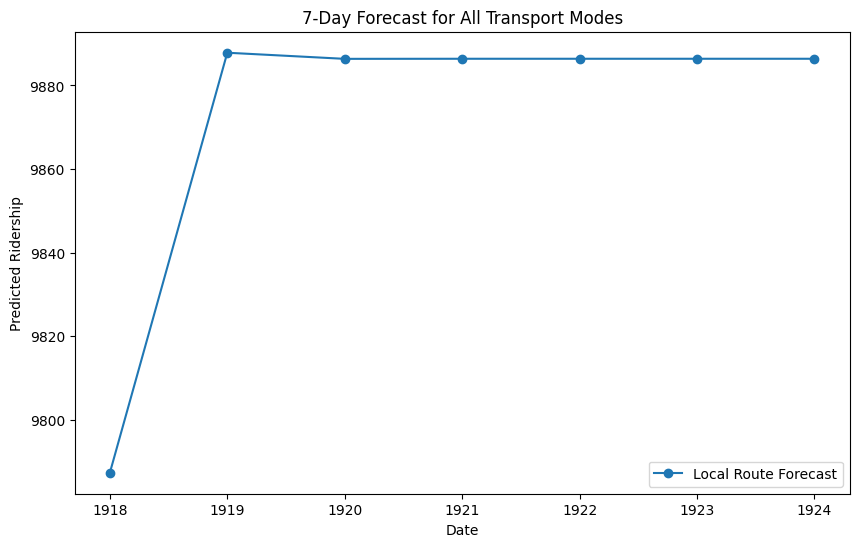

In [17]:
forecast_data = {
    'Local Route': results.get_forecast(steps=7).summary_frame()['mean'],
    # Repeat ARIMA for other columns (Rapid Route, Light Rail, etc.)
}

plt.figure(figsize=(10,6))
for mode, series in forecast_data.items():
    plt.plot(series.index, series, label=f'{mode} Forecast', marker='o')

plt.title('7-Day Forecast for All Transport Modes')
plt.xlabel('Date')
plt.ylabel('Predicted Ridership')
plt.legend()
plt.show()
